# INTRO

Для заказчика необходимо найти решение определения уровня сложности английского языка в фильмах по субтитрам.

Заказчик предоставил данные:
- английские словари Oxford, в которых слова распределены по уровню сложности
- набор файлов-субтитров, рассортированных по каталогам в соответствии с уровнем сложности
- excel файл со список несортированных фильмов и указанием их уровня

Цель:
- создание модели определения уровня сложности

Задачи:
- изучение и обработка предоставленного материала
- обработка текста субтитров и подготовка для машинного обучения
- расчет и добавление дополнительных признаков
- тестирование модели и подбор гиперпараметров
- выделение наиболее удачных признаков
- обучение оптимальной модели на датасете с наиболее полезными признаками
- создание приложения на платформе streamlit для демонстрации решения



In [1]:
import os
import re
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump, load

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, mean_squared_error, f1_score

import xgboost
import catboost

try:
    import spacy
    from spacy.lang.en import stop_words
except:
    !pip install spacy
    !python -m spacy download en
    import spacy
    from spacy.lang.en import stop_words

try:
    import chardet
except:
    !pip install chardet
    import chardet

try:
    from pypdf import PdfReader
except:
    !pip install pypdf
    from pypdf import PdfReader

try:
    import pysrt
except:
    !pip install pysrt
    import pysrt



In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
nlp = spacy.load("en_core_web_sm")

SCORES_PATH    = 'English_level/English_scores'
SUBTITLES_PATH = 'English_level/English_scores/Subtitles_all'
OXFORD_PATH    = 'English_level/Oxford_CEFR_level'

ENGLISH_LEVELS = ['A1', 'A2', 'B1', 'B2', 'C1']

RANDOM_STATE = 7

# LOAD DATA

## The Oxford core by CEFR level

В словарях Oxford 3000 и 5000 содержатся наиболее важные слова, которые должен знать каждый, кто учит английский.

Словарь Oxford соответствует стандартам CEFR – The Common European Framework of Reference for Languages. Это общеевропейские компетенции владения иностранным языком: изучение, преподавание, оценка — система уровней владения иностранным языком, используемая в Европейском Союзе.

У нас словари представлены в виде pdf-файлов.
- прочитаем их,
- разобьем на строки,
- выделим слова,
- определим уровень
- сохраним, из какого словаря взяли слово
- удалим дубликаты, оставим те случаи, где слову присвоена более высокая сложность
- выгрузим в joblib для дальнейшего использования в приложении Streamlit

In [3]:
def process_pdf(content):
    
    current_level = ''
    words_by_level = {key:[] for key in ENGLISH_LEVELS}
    
    for line in content:
        line = line.strip()

        if 'Oxford' in line or 'English' in line:
            pass
        
        elif line in ENGLISH_LEVELS:
            level = line
            
        elif ' ' in line:
            line = re.sub(r'\d|,', '', line.lower())   # remove digits and commas and transform to lowercase
            words_by_level[level] += [line.split()[0]] #get the first occurency in line as word
            
        else:
            pass
    
    return words_by_level


content = []
oxford_words = pd.DataFrame(columns=['word', 'level', 'source', 'type'])

# load all pdfs
for dirname, _, filenames in os.walk(OXFORD_PATH):
    for filename in filenames:
        print(filename)
        reader = PdfReader(f'{OXFORD_PATH}/{filename}')
        for page in reader.pages:
            content += page.extract_text().splitlines()
        processed = process_pdf(content)
        for level in processed:
            dict_type = 'us' if 'American' in filename else 'uk'
            oxford_words = pd.concat([oxford_words,
                                      pd.DataFrame({'word'   : processed[level],
                                                    'level'  : level,
                                                    'source' : filename,
                                                    'type'   : dict_type
                                                   })
                                     ])

# sort words and keep unique with higher levels
oxford_words = oxford_words.sort_values(by=['word', 'level'], ascending=True)
oxford_words = oxford_words.drop_duplicates(subset=['word'], keep='last')

# после сортировки и удаления дубликатов остался только американский инглиш
# похоже там все уровни слов считаются выше

oxford_words.groupby('level') \
            .agg({'word':'count', 'source': 'unique'}) \
            .style.format({'word':'{:,.0f} слов'})


American_Oxford_3000_by_CEFR_level.pdf
The_Oxford_3000_by_CEFR_level.pdf
The_Oxford_5000_by_CEFR_level.pdf
American_Oxford_5000_by_CEFR_level.pdf


,word,source
level,,
A1,735 слов,['American_Oxford_5000_by_CEFR_level.pdf']
A2,747 слов,['American_Oxford_5000_by_CEFR_level.pdf']
B1,758 слов,['American_Oxford_5000_by_CEFR_level.pdf']
B2,"1,446 слов",['American_Oxford_5000_by_CEFR_level.pdf']
C1,"1,198 слов",['American_Oxford_5000_by_CEFR_level.pdf']


In [4]:
dump(oxford_words,'oxford_dictionary.joblib')

['oxford_dictionary.joblib']

## Subtitles .srt

Субтитры у нас представлены в виде файлов .srt – это текстовые файлы, в которых информация представлены в таком виде:

        18
        00:04:59,796 --> 00:04:59,921
        - ( police radio chatter )
        - Man: What's the difference
    
То есть номер реплики, время и текст.

Файлы рассортированы по папкам, соответствующим уровням сложности языка..

Просканируем все файлы построчно:
- удалим из текста по возможности тэги, скобки, указания говорящего лица
- нетекстовые знаки, 
- лишние пробелы и переводы строки

Сохраним временные характеристики реплик:
- длительность реплики
- скорость речи в знаках в секунду
- скорость речи в словах в секунду

Соберем все в виде датасета для дальнейшей обработки.
    

In [14]:
# process line
def process_line(line):
    if re.search(r'[A-Za-z]',line): 
        line = line.lower()
        line = re.sub(r'\n', ' ', line)                            # remove new lines
        line = re.sub(r'- ', ' ', line)                            # remove dash
        line = re.sub(r'\<[^\<]+?\>', '', line)                    # remove html tags
        line = re.sub(r'\([^\(]+?\)', '', line)                    # remove () parenthesis
        line = re.sub(r'\[[^\[]+?\]', '', line)                    # remove [] parenthesis
        line = re.sub(r'^([\w#\s]+\:)', ' ', line)                 # remove speaker tag
        line = re.sub(r'[^[:alnum:][:punct:][:blank:]]',' ', line) # remove all other non-speach shars
        line = re.sub(r'\s\s+', ' ', line).strip()                 # remove extra spaces
    return line


# process text line by line   
def process_text(content):
    text = []
    duration  = []
    charsrate = []
    wordsrate  = []
    for item in content:
        if item.duration.ordinal>0:
            line = process_line(item.text_without_tags)
            text.append(line)
            duration.append(item.duration.to_time())
            charsrate.append(item.characters_per_second)
            wordsrate.append(len(line.split())/item.duration.ordinal*1000.0)
    return ' '.join(text), duration, charsrate, wordsrate


# process file
def process_srt(dirname, filename):
    global count
    if not filename.endswith('.srt'):                        # skip non srt files
        print('посторонний файл', filename)
        return False
    fullpath = os.path.join(dirname,filename)
    try:
        enc = chardet.detect(open(fullpath, "rb").read())['encoding']
        content = pysrt.open(fullpath, encoding=enc)
    except:
        print('не прочиталось', filename)
        return False
    return process_text(content)                            # clean text and return


# movies dataset template
movies = pd.DataFrame(columns=['filename', 
                               'content', 
                               'duration', 
                               'charsrate', 
                               'wordsrate', 
                               'level', 
                               'lemmas'] + ENGLISH_LEVELS + [l+'ratio' for l in ENGLISH_LEVELS]
                     )

# recursive walk through dirs
for dirname, _, filenames in os.walk(SUBTITLES_PATH):
    for filename in filenames:
        level  = dirname.split('/')[-1]                   # get level name from dir
        result = process_srt(dirname, filename)           # process file
        if result:                                        # add movie to dataframe
            subs, duration, charsrate, wordsrate = result
            movies.loc[len(movies)] = \
                {'filename' : filename.replace('.srt', ''),
                 'content'  : subs,
                 'duration' : duration, 
                 'charsrate': charsrate, 
                 'wordsrate': wordsrate, 
                 'level'    : level
                }

movies.head()

посторонний файл .DS_Store
посторонний файл .DS_Store


,filename,content,duration,charsrate,wordsrate,level,lemmas,A1,A2,B1,B2,C1,A1ratio,A2ratio,B1ratio,B2ratio,C1ratio
0,"Crown, The S01E01 - Wolferton Splash.en","in seeking his british nationalization, his ro...","[00:00:04.560000, 00:00:03.400000, 00:00:04.28...","[12.500000000000002, 11.176470588235295, 10.74...","[1.7543859649122808, 2.058823529411765, 1.4018...",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Suits.Episode 1- Denial,you're the most amazing woman i have ever met....,"[00:00:02.034000, 00:00:04.069000, 00:00:01.90...","[22.123893805309738, 9.584664536741213, 11.572...","[4.424778761061947, 1.9660850331776847, 1.5781...",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,i've been after sutter for three years now. t...,"[00:00:01.460000, 00:00:01.210000, 00:00:01.46...","[10.95890410958904, 34.710743801652896, 26.027...","[0.0, 6.6115702479338845, 5.47945205479452, 2....",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Suits.S02E08.HDTV.x264-EVOLVE,you're late. nope. 30 seconds early. good. le...,"[00:00:02.001000, 00:00:01.033000, 00:00:01.13...","[8.495752123938031, 11.616650532429817, 20.300...","[0.0, 1.936108422071636, 3.53045013239188, 2.7...",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE,are you sure i can't convince you to stay? no....,"[00:00:02.710000, 00:00:01, 00:00:02.170000, 0...","[15.498154981549815, 3.0, 19.81566820276498, 1...","[3.3210332103321036, 1.0, 4.608294930875576, 3...",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Excel labels processing

Часть файлов лежит в общем каталоге без указания уровня сложности. Для них заказчик предоставил excel-файл со списком фильмов и уровнями.
 
Загрузим файл и изучим его:
- удалим дубликаты
- поправим несовпадения названий
- из указанных уровней оставим более сложный вариант
- удалим фильмы, для которых нет информации по уровню сложности

In [33]:
movie_labels = pd.read_excel(f'{SCORES_PATH}/movies_labels.xlsx', index_col='id')
movie_labels.info()
movie_labels.columns = ['movie', 'level']
print('\nДубликаты полные', movie_labels.duplicated().sum())
print('Дубликаты в названиях фильмов', movie_labels.movie.duplicated().sum())
movie_labels = movie_labels.drop_duplicates()
movie_labels.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   241 non-null    object
 1   Level   241 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB

Дубликаты полные 2
Дубликаты в названиях фильмов 4


,movie,level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


In [114]:
# correct some mistakes in movies names
movie_labels.movie = movie_labels.movie.str.replace('.srt', '', regex=False)
movie_labels.loc[movie_labels.movie == 'Up (2009)', 'movie'] = 'Up(2009)'
movie_labels.loc[movie_labels.movie == 'The Grinch', 'movie'] = 'The.Grinch'

# удалим из level лишние символы, разделители оставим пробел
# из мультиуровней выберем наибольший
movie_labels.level = movie_labels.level \
                                 .str.replace(',', '', regex=False) \
                                 .str.replace('+', '', regex=False) \
                                 .str.replace('/', ' ', regex=False) \
                                 .str.split().transform(lambda x: max(x))

movie_labels.groupby('level').count().style.format({'movie':'{:.0f} фильмов'})

,movie
level,
A2,32 фильмов
B1,58 фильмов
B2,109 фильмов
C1,40 фильмов


In [31]:
# excel processing
for row in movie_labels.itertuples():

    n = movies.loc[movies.filename.str.contains(row.movie, regex=False)].shape[0]

    if n == 0:
        print('не найден текст', row.movie)

    elif n == 1:
        selected_movie_level = movies.loc[
            movies.filename.str.contains(row.movie, regex=False), 'level'].values[0]

        if selected_movie_level == 'Subtitles':         # replace Subtitles with excel level
             movies.loc[
                 movies.filename.str.contains(row.movie, regex=False), 'level'] = row.level

        elif selected_movie_level != row.level:          # replace with max current level or excel
             movies.loc[
                 movies.filename.str.contains(row.movie, regex=False), 'level'
             ] = max(selected_movie_level, row.level)

    else:
        print('не единственный текст', row.movie)


movies = movies[movies.level!='Subtitles']

# movies

не найден текст The Secret Life of Pets.en
не найден текст Glass Onion
не найден текст Matilda(2022)
не найден текст Bullet train
не найден текст Thor: love and thunder
не найден текст Lightyear


## Lemmatization

Подготовим текст для машинного обучения:
- оставляем только буквы, апострофы и пробелы 
- выполним лемматизацию – приведение слов к нормальной форме.

In [55]:
%%time
# movies content lemmatization
movies['lemmas'] = movies.content.transform(lambda text: 
                                            ' '.join([w.lemma_ for w 
                                                      in nlp(re.sub(r'[^a-z\s\']', '', text))
                                                     ]))

CPU times: user 8min 49s, sys: 12.6 s, total: 9min 2s
Wall time: 9min 3s


## Feature engineering

Рассчитаем и добавим численные признаки.

Количество слов (лемм):
- общее количество
- количество уникальных слов
- доля уников от общего количества

Сложность слов:
- подсчитаем количество уникальных слов каждого уровня
- доля слов каждой сложности относительно общего количества уников

Целевой признак перекодируем в порядовые числа.

In [56]:
# total lemmas count
# and unique lemmas count
# and unique ratio
movies['lemmas_count']  = movies.lemmas.transform(lambda x: len(x.split()))
movies['lemmas_unique'] = movies.lemmas.transform(lambda x: len(set(x.split())))
movies['lemmas_unique_ratio'] = movies.lemmas_unique / movies.lemmas_count

In [57]:
# oxford words in movies lemmas
def count_words_by_level(row):
    row_lemmas = row.lemmas.split()
    total_score = oxford_words.loc[oxford_words.word.isin(row_lemmas)] \
                              .groupby('level').word.count().to_dict()
    row[total_score.keys()] = total_score
    return row

movies = movies.apply(count_words_by_level, axis=1)

# ratio oxford words in content
for l in ENGLISH_LEVELS:
    movies[l+'ratio'] = movies[l]/movies.lemmas_unique

In [58]:
# count words by length
# and ratio to total count
for i in range(1,10):
    equal_col = 'len_equal_'+str(i)
    more_col  = 'more_than_'+str(i)
    less_col  = 'less_than_'+str(i)
    
    movies[equal_col] = movies.lemmas.transform(lambda x: sum(len(word)==i for word in x.split()))
    movies[more_col]  = movies.lemmas.transform(lambda x: sum(len(word)>i for word in x.split()))
    movies[less_col]  = movies.lemmas.transform(lambda x: sum(len(word)<i for word in x.split()))
    
    movies[equal_col + 'ratio'] = movies[equal_col] / movies.lemmas_count
    movies[more_col + 'ratio']  = movies[more_col] / movies.lemmas_count
    movies[less_col + 'ratio']  = movies[less_col] / movies.lemmas_count
    

In [62]:
# encode level to ordinal values
# fill missing values
# export data movies to csv
movies['target'] = movies.level.replace({'A1':1, 'A2':2, 'B1':3, 'B2':4, 'C1':5, 'C2':6})
movies = movies.fillna(0)
movies.to_csv('movies_df.csv', index=False)

try:
    os.system('say "data processing completed"')
except:
    pass

# MODELS TEST

In [63]:
movies = pd.read_csv('movies_df.csv')


In [118]:
text = 'lemmas'

lemmas_num = ['lemmas_count', 'lemmas_unique', 'lemmas_unique_ratio']

levels_ratio = [l+'ratio' for l in ENGLISH_LEVELS]

equal_ratio = [c+'ratio' for c in length_equal]
more_ratio  = [c+'ratio' for c in length_more]
less_ratio  = [c+'ratio' for c in length_less]

num = [*lemmas_num,
       *levels_ratio,
       *equal_ratio,
       *more_ratio,
       *less_ratio,
      ]


In [119]:
X_train, X_test, y_train, y_test = train_test_split(movies, 
                                                    movies.target,
                                                    stratify=movies.target,
                                                    random_state=RANDOM_STATE,
                                                    test_size=0.3
                                                   )


In [120]:
# vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()
scaler     = StandardScaler()

preprocessor = ColumnTransformer([
    ('num', scaler, num),
    ('txt', vectorizer,  text)
], remainder='drop')


## Regressor

In [121]:
%%time

params = {
    'pre__txt__stop_words'  : [None, 'english', list(stop_words.STOP_WORDS)+['ll', 've']],
    'pre__txt__ngram_range' : [(1,1), (1,2), (1,3)],
    'pre__txt__max_features': [None, 1000],
    'pre__txt__min_df'      : [1, 10, 100],
    'reg__learning_rate'    : [0.05, 0.1, 0.2],
    'reg__n_estimators'     : [50, 100, 200],
    'reg__max_depth'        : [3, 5, 7],
    'reg__min_child_weight' : [1, 3, 5],
    'reg__gamma'            : [0, 0.1, 0.5, 1],
    'reg__subsample'        : [0.6, 0.8, 1.0],
    'reg__colsample_bytree' : [0.6, 0.8, 1.0],
    'reg__reg_alpha'        : [0, 0.1, 1],
    'reg__reg_lambda'       : [0, 0.1, 1],
    'reg__gamma'            : [0, 1, 5]
}

regressor = xgboost.XGBRegressor(random_state=RANDOM_STATE)

pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', regressor)
])

rc = RandomizedSearchCV(pipeline,
                        param_distributions=params,
                        scoring='neg_mean_squared_error',
                        error_score='raise',
                        random_state=RANDOM_STATE,
                        n_jobs=-1
                       )

rc.fit(X_train,y_train)

try:
    os.system('say "Model training completed"')
except:
    pass

-rc.best_score_

CPU times: user 59.9 s, sys: 3.85 s, total: 1min 3s
Wall time: 1min 59s


0.44642488448006884

In [122]:
rc

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['lemmas_count',
                                                                                'lemmas_unique',
                                                                                'lemmas_unique_ratio',
                                                                                'A1ratio',
                                                                                'A2ratio',
                                                                                'B1ratio',
                                                                                'B2ratio',
                                                                                'C1ratio',
                                                                                'len_equal_1ratio',
                                                                                'len_equal_2ratio',
                                                                                'len_equal_3ratio',
                                                                                'len_equal_4ratio',
                                                                                'len_equal_5ratio',
                                                                                'len_equal_6ratio',
                                                                                'len...
                                                                  'meanwhile',
                                                                  'myself',
                                                                  'there', ...]],
                                        'reg__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'reg__gamma': [0, 1, 5],
                                        'reg__learning_rate': [0.05, 0.1, 0.2],
                                        'reg__max_depth': [3, 5, 7],
                                        'reg__min_child_weight': [1, 3, 5],
                                        'reg__n_estimators': [50, 100, 200],
                                        'reg__reg_alpha': [0, 0.1, 1],
                                        'reg__reg_lambda': [0, 0.1, 1],
                                        'reg__subsample': [0.6, 0.8, 1.0]},
                   random_state=7, scoring='neg_mean_squared_error')

In [123]:
rc.best_params_

{'reg__subsample': 1.0,
 'reg__reg_lambda': 1,
 'reg__reg_alpha': 1,
 'reg__n_estimators': 100,
 'reg__min_child_weight': 5,
 'reg__max_depth': 3,
 'reg__learning_rate': 0.1,
 'reg__gamma': 0,
 'reg__colsample_bytree': 1.0,
 'pre__txt__stop_words': None,
 'pre__txt__ngram_range': (1, 3),
 'pre__txt__min_df': 1,
 'pre__txt__max_features': None}

In [124]:
dump(rc, 'model_english_level.joblib')


['model_english_level.joblib']

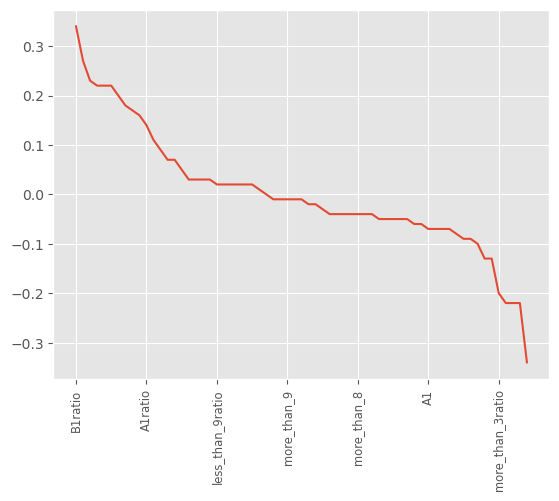

In [125]:
movies.corrwith(movies.target)[:-1].round(2).sort_values(ascending=False).plot()
plt.xticks(rotation=90,size='small')
plt.show()

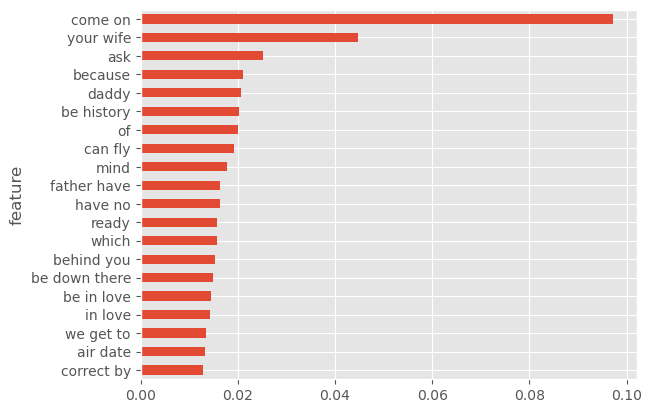

In [126]:
feature_names = rc.best_estimator_[0].get_feature_names_out()
feature_importances = rc.best_estimator_[-1].feature_importances_
fi = pd.DataFrame({'feature':feature_names, 'weight': feature_importances})
fi.feature = fi.feature.str[5:]

fi.sort_values(by='weight', ascending=False) \
  .head(20).sort_values(by='weight',ascending=True) \
  .plot(kind='barh', y='weight', x='feature', legend=False)
plt.show()

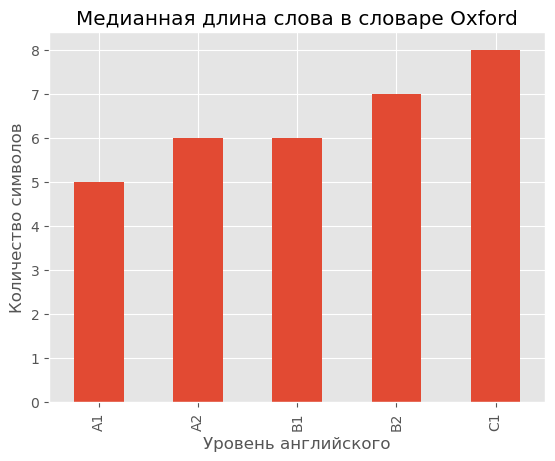

In [127]:
oxford_words['length'] = oxford_words.word.str.len()
oxford_words.groupby('level').length.median().plot(kind='bar')
plt.title('Медианная длина слова в словаре Oxford')
plt.ylabel('Количество символов')
plt.xlabel('Уровень английского')
plt.show()